This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957 to August 7th 2020.

In [1]:
%pip install iso3166

Note: you may need to restart the kernel to use updated packages.


### Import Statements

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from iso3166 import countries
from datetime import datetime, timedelta

### Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [4]:
df_data = pd.read_csv('mission_launches.csv')

## Preliminary Data Exploration

Shape of the dataframe:

In [5]:
shape = df_data.shape
print(f"rows: {shape[0]}")
print(f"columns: {shape[1]}")

rows: 4324
columns: 9


Columns of the dataframe:

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    4324 non-null   int64 
 1   Unnamed: 0      4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


## Data Cleaning & Preparation


In [7]:
print(df_data.head())
print(df_data.tail())

   Unnamed: 0.1  Unnamed: 0 Organisation  \
0             0           0       SpaceX   
1             1           1         CASC   
2             2           2       SpaceX   
3             3           3    Roscosmos   
4             4           4          ULA   

                                            Location  \
0         LC-39A, Kennedy Space Center, Florida, USA   
1  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2                      Pad A, Boca Chica, Texas, USA   
3       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4           SLC-41, Cape Canaveral AFS, Florida, USA   

                         Date                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  

In [8]:
print(f"mssing values: {df_data.isna().values.any()}")
print(f"duplicates: {df_data.duplicated().values.any()}")

mssing values: True
duplicates: False


In [9]:
print(f"number of missing values: {df_data.isna().value_counts()}")

number of missing values: Unnamed: 0.1  Unnamed: 0  Organisation  Location  Date   Detail  Rocket_Status  Price  Mission_Status
False         False       False         False     False  False   False          True   False             3360
                                                                                False  False              964
dtype: int64


Cleaned dataframe:

In [10]:
cleaned_df = df_data.dropna()

# drop the first two columns
cleaned_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

# convert Date to datetime
cleaned_df.Date = pd.to_datetime(cleaned_df.Date, utc=True)

# convert Price to numeric
cleaned_df.Price = cleaned_df.Price.astype(str).str.replace(',', '')
cleaned_df.Price = pd.to_numeric(cleaned_df.Price)

# get the country as location
country = []
for row in cleaned_df.Location.astype(str).str.split(','):
    country.append(row[-1])
cleaned_df.Location = country

print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 4020
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Organisation    964 non-null    object             
 1   Location        964 non-null    object             
 2   Date            964 non-null    datetime64[ns, UTC]
 3   Detail          964 non-null    object             
 4   Rocket_Status   964 non-null    object             
 5   Price           964 non-null    float64            
 6   Mission_Status  964 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), object(5)
memory usage: 60.2+ KB
None


/var/folders/8c/6tdsqhpj0b76d5rq5bg9j3740000gn/T/ipykernel_90872/2976452355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
/var/folders/8c/6tdsqhpj0b76d5rq5bg9j3740000gn/T/ipykernel_90872/2976452355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.Date = pd.to_datetime(cleaned_df.Date, utc=True)
/var/folders/8c/6tdsqhpj0b76d5rq5bg9j3740000gn/T/ipykernel_90872/2976452355.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [21]:
# clean the original Dataframe
df_data.Date = pd.to_datetime(df_data.Date, utc=True)
country_original = []
for row in df_data.Location.astype(str).str.split(','):
    if row[-1].strip() == 'Russia' or row[-1].strip() == 'Barents Sea':
        country_original.append('RUS')
    elif row[-1].strip() == 'Shahrud Missile Test Site' or row[-1].strip() == 'Iran':
        country_original.append('IRN')
    elif row[-1].strip() == 'New Mexico' or row[-1].strip() == 'Pacific Missile Range Facility' \
            or row[-1].strip() == 'Pacific Ocean' or row[-1].strip() == 'Gran Canaria':
        country_original.append('USA')
    elif row[-1].strip() == 'Yellow Sea':
        country_original.append('CHN')
    elif row[-1].strip() == 'North Korea':
        country_original.append('PRK')
    elif row[-1].strip() == 'South Korea':
        country_original.append('KOR')
    else:
        try:
            country_original.append(countries.get(row[-1].strip())[2])
        except KeyError:
            country_original.append('')
df_data.Location = country_original
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Unnamed: 0.1    4324 non-null   int64              
 1   Unnamed: 0      4324 non-null   int64              
 2   Organisation    4324 non-null   object             
 3   Location        4324 non-null   object             
 4   Date            4324 non-null   datetime64[ns, UTC]
 5   Detail          4324 non-null   object             
 6   Rocket_Status   4324 non-null   object             
 7   Price           964 non-null    object             
 8   Mission_Status  4324 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 304.2+ KB
None


## Descriptive Statistics

In [23]:
cleaned_df.describe()

,Price
count,964.00
mean,153.79
std,288.45
min,5.30
25%,40.00
50%,62.00
75%,164.00
max,"5,000.00"


# Number of Launches per Company

Chart that shows the number of space mission launches by organisation.

*When there are no price informations needed, I will use the converted original DataFrame to cover the right amount of launches from each country*

In [26]:
# I used the original DataFrame because the launches from e.g. RVSN USSR would otherwise be excluded
print("Number of Launches per Company")
launches = df_data.groupby('Organisation').count().sort_values('Detail', ascending=False)['Detail']
print(launches)

Number of Launches per Company
Organisation
RVSN USSR           1777
Arianespace          279
General Dynamics     251
CASC                 251
NASA                 203
VKS RF               201
US Air Force         161
ULA                  140
Boeing               136
Martin Marietta      114
SpaceX               100
MHI                   84
Northrop              83
Lockheed              79
ISRO                  76
Roscosmos             55
ILS                   46
Sea Launch            36
ISAS                  30
Kosmotras             22
US Navy               17
Eurockot              13
ISA                   13
Rocket Lab            13
ESA                   13
Blue Origin           12
IAI                   11
ExPace                10
ASI                    9
CNES                   8
AMBA                   8
Land Launch            7
MITT                   7
JAXA                   7
UT                     5
CASIC                  5
KCST                   5
CECLES                 4
Exos  

In [25]:
launches_bar = px.bar(
    x=launches.index,
    y=launches.values,
    title='Number of Launches per Company'
)
launches_bar.update_layout(xaxis_title='Number of Launches', yaxis_title='Organisation')
launches_bar.show()

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

In [15]:
status = df_data.groupby('Rocket_Status').count()['Detail']
status

Rocket_Status
StatusActive      790
StatusRetired    3534
Name: Detail, dtype: int64

In [16]:
status_pie = px.pie(
    labels=status.index,
    values=status.values,
    title='Number of Active vs. Retired Rocktes',
    names=status.index
)
status_pie.show()

/Users/felixschwebel/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [17]:
mission_status = df_data.groupby('Mission_Status').count()['Detail']
mission_status

Mission_Status
Failure               339
Partial Failure       102
Prelaunch Failure       4
Success              3879
Name: Detail, dtype: int64

In [18]:
mission_status_pie = px.pie(
    labels=mission_status.index,
    values=mission_status.values,
    title='Distribution of Mission Status',
    names=mission_status.index
)
mission_status_pie.show()

/Users/felixschwebel/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



# How Expensive are the Launches? 

Histogram and visualise the distribution (price column in USD millions).

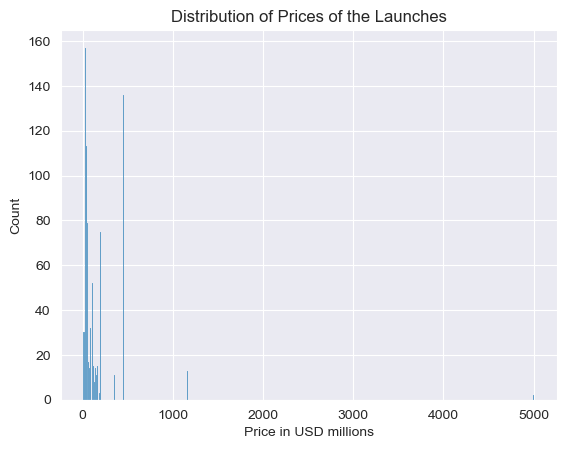

In [41]:
hist = sns.histplot(
    data=cleaned_df,
    x=cleaned_df.Price,
    bins=1000,
)
plt.xlabel("Price in USD millions")
plt.title('Distribution of Prices of the Launches')
plt.show()

# Choropleth Map to Show the Number of Launches by Country

In [19]:
num_launches = px.choropleth(
    locations=df_data.groupby('Location').count().index,
    color=df_data.groupby('Location').count()['Detail'],
    color_continuous_scale='matter',
)
num_launches.show()

# Choropleth Map to Show the Number of Failures by Country


# Plotly Sunburst Chart of the countries, organisations, and mission status.

# Total Amount of Money Spent by Organisation on Space Missions

# Amount of Money Spent by Organisation per Launch

# Number of Launches per Year

Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time?

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

# How has the Launch Price varied Over Time? 

Line chart that shows the average price of rocket launches over time.

# Number of Launches over Time by the Top 10 Organisations.

How has the dominance of launches changed over time between the different players? 

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. 

## Plotly Pie Chart comparing the total number of launches of the USSR and the USA

## Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

## Total Number of Mission Failures Year on Year.

## Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time? 

# Which Country was in the Lead in terms of Total Number of Launches up to and including 2020?

Do the results change if we only look at the number of successful launches? 

# Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020? 